# prototyping LSS pipeline

## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
import sys
sys.path.append('/home/alf/Desktop/LSS/FergLabLSS/LSS_components')
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [6]:
# DESRES Chignolin at 340 K
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = pdb_dir
trj_file = []
for i in np.arange(0,10):
    fname = "1FME-1-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
print(pdb_file)

print(pdb_file)
view = nv.show_structure_file(pdb_file)
view.clear_representations()
view.add_ball_and_stick()
view

/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/system.pdb
/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/system.pdb


NGLWidget()

### mdtraj load and view

In [7]:
traj_obj = md.load(trj_file, top=pdb_file)

In [8]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

<mdtraj.Trajectory with 100000 frames, 504 atoms, 28 residues, and unitcells at 0x7f1b7acd6080>

In [9]:
view = nv.show_mdtraj(traj_obj)
view.clear_representations()
view.add_spacefill()
view

NGLWidget(count=100000)

#### h2t

In [10]:
Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

In [11]:
h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

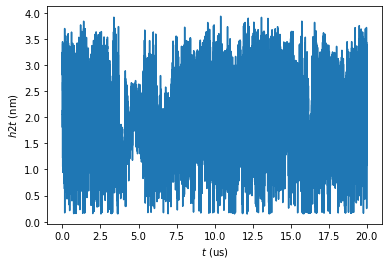

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, h2t)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

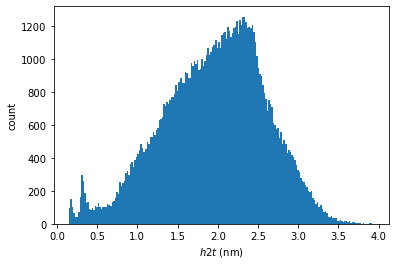

In [13]:
fig, ax = plt.subplots()
_ = plt.hist(h2t, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$h2t$ (nm)")
plt.show()

#### RMSD

In [14]:
view = nv.show_mdtraj(traj_obj[25000])
view.clear_representations()
view.add_spacefill()
view

NGLWidget()

In [15]:
rmsd = md.rmsd(traj_obj,traj_obj[25000],0)

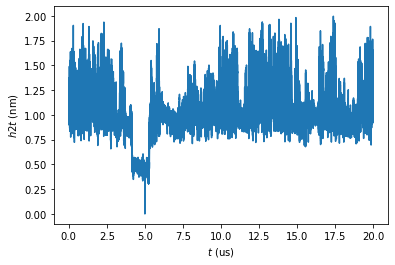

In [16]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, rmsd)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

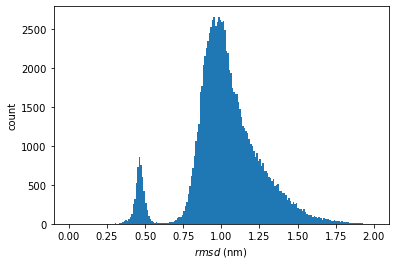

In [17]:
fig, ax = plt.subplots()
_ = plt.hist(rmsd, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$rmsd$ (nm)")
plt.show()

#### dihedrals

## featurization

In [20]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

18-02-21 21:10:25 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[1] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 3744


In [21]:
data = np.genfromtxt("data.txt")

ValueError: Some errors were detected !
    Line #2 (got 4 columns instead of 7)
    Line #3 (got 2 columns instead of 7)
    Line #4 (got 4 columns instead of 7)
    Line #5 (got 4 columns instead of 7)
    Line #6 (got 4 columns instead of 7)
    Line #7 (got 5 columns instead of 7)
    Line #8 (got 4 columns instead of 7)
    Line #9 (got 4 columns instead of 7)
    Line #10 (got 5 columns instead of 7)
    Line #11 (got 4 columns instead of 7)
    Line #12 (got 4 columns instead of 7)
    Line #13 (got 4 columns instead of 7)
    Line #14 (got 4 columns instead of 7)
    Line #15 (got 4 columns instead of 7)
    Line #16 (got 2 columns instead of 7)
    Line #17 (got 1 columns instead of 7)
    Line #19 (got 3 columns instead of 7)
    Line #20 (got 3 columns instead of 7)
    Line #22 (got 4 columns instead of 7)
    Line #23 (got 4 columns instead of 7)
    Line #24 (got 4 columns instead of 7)
    Line #25 (got 4 columns instead of 7)
    Line #26 (got 3 columns instead of 7)
    Line #27 (got 3 columns instead of 7)
    Line #28 (got 1 columns instead of 7)
    Line #30 (got 2 columns instead of 7)
    Line #31 (got 1 columns instead of 7)
    Line #33 (got 4 columns instead of 7)
    Line #42 (got 3 columns instead of 7)
    Line #44 (got 4 columns instead of 7)
    Line #45 (got 4 columns instead of 7)
    Line #47 (got 3 columns instead of 7)
    Line #48 (got 3 columns instead of 7)
    Line #49 (got 4 columns instead of 7)
    Line #51 (got 2 columns instead of 7)
    Line #52 (got 1 columns instead of 7)
    Line #54 (got 1 columns instead of 7)
    Line #55 (got 3 columns instead of 7)
    Line #56 (got 1 columns instead of 7)
    Line #57 (got 1 columns instead of 7)
    Line #58 (got 1 columns instead of 7)
    Line #62 (got 4 columns instead of 7)
    Line #64 (got 1 columns instead of 7)
    Line #65 (got 1 columns instead of 7)
    Line #67 (got 3 columns instead of 7)
    Line #68 (got 1 columns instead of 7)
    Line #69 (got 1 columns instead of 7)
    Line #70 (got 1 columns instead of 7)
    Line #75 (got 9 columns instead of 7)
    Line #77 (got 8 columns instead of 7)
    Line #79 (got 4 columns instead of 7)
    Line #80 (got 2 columns instead of 7)
    Line #81 (got 2 columns instead of 7)
    Line #82 (got 2 columns instead of 7)
    Line #83 (got 1 columns instead of 7)
    Line #85 (got 4 columns instead of 7)
    Line #86 (got 4 columns instead of 7)
    Line #87 (got 1 columns instead of 7)
    Line #88 (got 2 columns instead of 7)
    Line #89 (got 1 columns instead of 7)
    Line #93 (got 3 columns instead of 7)
    Line #94 (got 1 columns instead of 7)
    Line #95 (got 1 columns instead of 7)
    Line #96 (got 1 columns instead of 7)
    Line #98 (got 3 columns instead of 7)
    Line #100 (got 4 columns instead of 7)
    Line #101 (got 2 columns instead of 7)
    Line #102 (got 2 columns instead of 7)
    Line #103 (got 2 columns instead of 7)
    Line #104 (got 1 columns instead of 7)
    Line #106 (got 4 columns instead of 7)
    Line #107 (got 4 columns instead of 7)
    Line #108 (got 1 columns instead of 7)
    Line #109 (got 2 columns instead of 7)
    Line #110 (got 1 columns instead of 7)
    Line #114 (got 5 columns instead of 7)
    Line #115 (got 5 columns instead of 7)
    Line #116 (got 5 columns instead of 7)
    Line #117 (got 5 columns instead of 7)
    Line #119 (got 6 columns instead of 7)
    Line #120 (got 4 columns instead of 7)
    Line #121 (got 2 columns instead of 7)
    Line #122 (got 2 columns instead of 7)
    Line #123 (got 2 columns instead of 7)
    Line #124 (got 1 columns instead of 7)
    Line #126 (got 6 columns instead of 7)
    Line #127 (got 4 columns instead of 7)
    Line #128 (got 2 columns instead of 7)
    Line #129 (got 2 columns instead of 7)
    Line #130 (got 2 columns instead of 7)
    Line #131 (got 1 columns instead of 7)
    Line #133 (got 6 columns instead of 7)
    Line #134 (got 4 columns instead of 7)
    Line #135 (got 2 columns instead of 7)
    Line #136 (got 2 columns instead of 7)
    Line #137 (got 2 columns instead of 7)
    Line #138 (got 1 columns instead of 7)
    Line #140 (got 6 columns instead of 7)
    Line #141 (got 4 columns instead of 7)
    Line #142 (got 2 columns instead of 7)
    Line #143 (got 2 columns instead of 7)
    Line #144 (got 2 columns instead of 7)
    Line #145 (got 1 columns instead of 7)
    Line #150 (got 3 columns instead of 7)
    Line #151 (got 1 columns instead of 7)
    Line #152 (got 2 columns instead of 7)
    Line #153 (got 3 columns instead of 7)
    Line #154 (got 1 columns instead of 7)
    Line #157 (got 5 columns instead of 7)
    Line #159 (got 3 columns instead of 7)
    Line #160 (got 4 columns instead of 7)
    Line #161 (got 4 columns instead of 7)
    Line #162 (got 4 columns instead of 7)
    Line #163 (got 1 columns instead of 7)
    Line #164 (got 1 columns instead of 7)
    Line #167 (got 1 columns instead of 7)

## (1) latent space projection

### parameters

In [ ]:
lag=50
dim=5
is_reversible=True

### SRV

In [ ]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [ ]:
hde = pickle.load(open('bba_hde.pkl', 'rb'))

In [ ]:
hde_coords = hde.transform(data, side='left')
#hde_coords_right = hde.transform(data, side='right')
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
#print(hde_coords_right)

In [ ]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(hde_coords[:,0],hde_coords[:,1], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$\psi_2$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

In [ ]:
# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(hde_coords[:, 0], hde_coords[:, 1], hde_coords[:, 2], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

In [ ]:
# 1D PMF
pdf, bin_edges = np.histogram(hde_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
# pyemma distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    hde_coords, ['SRV {}'.format(i + 1) for i in range(dim)], ax=axes[0])
py.plots.plot_density(*hde_coords[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*hde_coords[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('SRV 1')
    ax.set_ylabel('SRV 2')
fig.tight_layout()

In [ ]:
def plot_its(lags, its, its_stderr, dim, data_name, ax, marker='o'):

    colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']

    for i in range(dim):
        ax.plot(lags,its[:,i].flatten(), marker=marker, color=colors[i], label=data_name + ' $t$' + str(i))
        ax.fill_between(lags, its[:,i].flatten() - its_stderr[:,i].flatten(), its[:,i].flatten() + its_stderr[:,i].flatten(), alpha=0.2, color=colors[i])
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.set_ylim(ymin = np.min(lags))
    ax.set_yscale('log')
    ax.legend(loc='lower right')

In [ ]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(hde_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(hde_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_SRV = copy.deepcopy(its)
its_SRV_stderr = copy.deepcopy(its_stderr)

### tICA

In [ ]:
tica = py.coordinates.tica(data, dim=dim, lag=lag)
tica_coords = tica.get_output()[0]
print(tica.timescales[:dim])
print(tica_coords)

In [ ]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(tica_coords[:,0], tica_coords[:,1], c=np.arange(tica_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

In [ ]:
# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(tica_coords[:, 0], tica_coords[:, 1], tica_coords[:, 2], c=np.arange(tica_coords.shape[0]), alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

In [ ]:
# 1D PMF
pdf, bin_edges = np.histogram(tica_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
# pyemma distributions
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    tica_concatenated, ['TIC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
fig.tight_layout()

In [ ]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(tica_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(tica_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_TICA = copy.deepcopy(its)
its_TICA_stderr = copy.deepcopy(its_stderr)

### SRVs vs. tICA implied time scales

In [ ]:
# implied time scales: SRVs vs. tICA

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its_SRV, its_SRV_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')
plot_its(lags, its_TICA, its_TICA_stderr, dim, 'tICA', ax[0], marker='v')

plot_its(lags*timestep/1E3, its_SRV*timestep/1E3, its_SRV_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')
plot_its(lags*timestep/1E3, its_TICA*timestep/1E3, its_TICA_stderr*timestep/1E3, dim, 'tICA', ax[1], marker='v')

plt.show()

In [ ]:
# 2D scatterplot
fig, ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,0], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label(r'$\psi_1$ ($t_1$ = ' + str(np.round(hde_timescales[0]*timestep/1E3,2)) + ' ns)')
ax[0].set_xlabel('TIC1')
ax[0].set_ylabel('TIC2')

im = ax[1].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,1], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'$\psi_2$ ($t_2$ = ' + str(np.round(hde_timescales[1]*timestep/1E3,2)) + ' ns)')
ax[1].set_xlabel('TIC1')
ax[1].set_ylabel('TIC2')

plt.show

### kernel TICA

### SRV k-means clustering

#### n_cluster optimization using silhouette score

- expect n_cluster = (dim_kmeans+1) similar to PCCA (# macrostates = 1 + # singular vectors)

- Idea of inner simplex (PCCA) clustering directly in singular vectors of transfer operator:
F. Paul, H. Wu, M. Vossel, B.L. de Groot, and F. Noe "Identification of kinetic order parameters
for non-equilibrium dynamics" J. Chem. Phys. 150, 164120 (2019); doi: 10.1063/1.5083627

- k-means simpler and only for understanding of macrostates not construction of MSM

In [ ]:
dim_kmeans = 2
hde_coords_kmeans = copy.deepcopy(hde_coords[:,:dim_kmeans])

In [ ]:
range_n_clusters = np.arange(2,5,1)
silhouette_avg_array = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=200184)
    cluster_labels = clusterer.fit_predict(hde_coords_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(hde_coords_kmeans, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_array.append(silhouette_avg)

In [ ]:
n_clusters = dim_kmeans+1 # usually, but check silhouette scores

In [ ]:
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(hde_coords_kmeans)
centers = clusterer.cluster_centers_
sample_silhouette_values = silhouette_samples(hde_coords_kmeans, cluster_labels)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im1 = ax1.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_xlabel("$\psi_1$")
ax1.set_ylabel("$\psi_2$")

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im2 = ax2.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=sample_silhouette_values, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_xlabel("$\psi_1$")
ax2.set_ylabel("$\psi_2$")
cbar = fig.colorbar(im2, ax=ax2)
cbar.set_label('silhouette score')

plt.show()

#### visualizing configs proximate to k-means centers

In [ ]:
centers

In [ ]:
kmeans_viz = []
for i in range(n_clusters):
    idx_sort = np.argsort(np.sqrt(np.sum((hde_coords_kmeans - centers[i,:])**2, axis=1)))
    kmeans_viz.append(idx_sort[:10])

In [ ]:
for i in range(n_clusters):
    print(hde_coords_kmeans[kmeans_viz[i][0],:])

In [ ]:
clust_id = 0
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
clust_id = 1
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
clust_id = 2
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
view = nv.NGLWidget()
view.add_trajectory(traj_obj[kmeans_viz[0][0]])
view.component_0.clear_representations()
view.component_0.add_cartoon(color='blue', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[1][0]])
view.component_1.clear_representations()
view.component_1.add_cartoon(color='red', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[2][0]])
view.component_2.clear_representations()
view.component_2.add_cartoon(color='green', opacity=0.8)
view

## (2) propagator

In [ ]:
dim_prop = 2

In [ ]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [ ]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [ ]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [ ]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

In [ ]:
from hde.propagator import get_mixture_loss_func

In [ ]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [ ]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [ ]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

In [ ]:
synth_traj_id = 0
fig, ax = plt.subplots()

if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeors(hde_coords[::lag_prop,0].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,0], hde_coords[::lag_prop,1], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], synth_trajs[synth_traj_id][:,1], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

In [ ]:
synth_traj_id = 1
psi_id = 0

fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], color='blue', alpha=0.5, marker='o')
ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$'+str(psi_id+1))
plt.show()

## (3) generator

#### x_train = scaled latent space coordinates

In [ ]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [ ]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [ ]:
traj_ca.superpose(traj_ca[0])

In [ ]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

In [ ]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [ ]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [ ]:
y_train = xyz_scaler.fit_transform(xyz)

In [ ]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [ ]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

In [ ]:
def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted = True# need to override after loading to allow molgen.transform to proceed


#### decoding synthetic propagator trajectories

In [ ]:
assert molgen.is_fitted == True

In [ ]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)
xyz_synth

In [ ]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [ ]:
traj_ca[0].save_pdb('synth.pdb')

In [ ]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [ ]:
traj_ca_synth

In [ ]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [ ]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

In [ ]:
view = nv.show_mdtraj(traj_synth_obj)
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [ ]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [ ]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [ ]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

In [ ]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [ ]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [ ]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

In [ ]:
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, pmf_LSS, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [ ]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

### kinetic (relaxation times)

In [ ]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [ ]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

In [ ]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [ ]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

In [ ]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

In [ ]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

In [ ]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_LSS[0,i], relax_LSS_stderr[i]))

### structure (RMSD)

In [ ]:
#xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [ ]:
def writeToXYZ(xyz_coordinates, filename):
    with open(filename, 'w') as f:
        for i in range(xyz_coordinates.shape[0]):
            f.write('%d\n' % n_atoms)
            f.write('\n')
            for k in range(n_atoms):
                f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

                
def xyzToTraj(xyz_coordinates,fn="temp.xyz"):
    writeToXYZ(xyz_coordinates, fn)
    traj = md.load(fn, top='synth.pdb')
    return traj

In [ ]:
'''
    ~~~RMSD Calculation~~~
    k = frames where the indexed LSS trajectory is in the metastable basin1
    l = frames where the MD obj trajectory is in the mestable basin1
    
    n = frames where the indexed LSS trajectory is in the metastable basin2
    m = frames where the MD obj trajectory is in the mestable basin2

    t = traj containing all corresponding LSS frames for basin 1
    s = traj containing all corresponding LSS frames for basin 2
    
'''
lowerBasin1 = -1.4
upperBasin1 = -1.2

lowerBasin2 = 0.6
upperBasin2 = 0.8


l = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin1, hde_coords[:,0]<=upperBasin1))
m = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))


for i in range(len(synth_trajs)):
    print("Finding Frames for Traj ",i)
    k = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin1, synth_trajs[0][:,0]<=upperBasin1))
    n = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin2, synth_trajs[0][:,0]<=upperBasin2))
    xyzi = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[i])).reshape(-1, n_atoms, 3)
    if(i == 0): t = xyzToTraj(xyzi)[k]
    else: t = md.join([t,xyzToTraj(xyzi)[k]])
    if(i == 0): s = xyzToTraj(xyzi)[n]
    else: s = md.join([t,xyzToTraj(xyzi)[n]])

In [ ]:
rmsd1 = np.mean(md.rmsd(t, traj_ca[l]))
rmsd2 = np.mean(md.rmsd(s, traj_ca[m]))
print("Basin One RMSD is ", rmsd1, " nm. Found ", len(t), "LSS frames in Basin One and ", len(l[0]), " MD frames")
print("Basin Two RMSD is ", rmsd2, " nm. Found ", len(s), "LSS frames in Basin Two and ", len(m[0]), " MD frames")

In [ ]:
np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))

In [ ]:
# prototyping LSS pipeline

## setup

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import sys
sys.path.append('/home/alf/Desktop/LSS/FergLabLSS/LSS_components')
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

# DESRES Chignolin at 340 K
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = pdb_dir
trj_file = []
for i in np.arange(0,10):
    fname = "1FME-1-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
print(pdb_file)

print(pdb_file)
view = nv.show_structure_file(pdb_file)
view.clear_representations()
view.add_ball_and_stick()
view

### mdtraj load and view

traj_obj = md.load(trj_file, top=pdb_file)

traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

view = nv.show_mdtraj(traj_obj)
#view.clear_representations()
#view.add_spacefill()
view

#### h2t

Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, h2t)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

fig, ax = plt.subplots()
_ = plt.hist(h2t, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$h2t$ (nm)")
plt.show()

#### RMSD

view = nv.show_mdtraj(traj_obj[25000])
#view.clear_representations()
#view.add_spacefill()
view

rmsd = md.rmsd(traj_obj,traj_obj[25000],0)

fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, rmsd)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

fig, ax = plt.subplots()
_ = plt.hist(rmsd, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$rmsd$ (nm)")
plt.show()

#### dihedrals

dih_phi = md.compute_phi(traj_obj, periodic=True, opt=True)
dih_psi = md.compute_psi(traj_obj, periodic=True, opt=True)
dih_omega = md.compute_omega(traj_obj, periodic=True, opt=True)
dih_chi1 = md.compute_chi1(traj_obj, periodic=True, opt=True)

fig, ax = plt.subplots(dih_phi[1].shape[1], 1, figsize=(15,50))
for i in range(dih_phi[1].shape[1]):
    ax[i].scatter(np.arange(dih_phi[1].shape[0])*timestep/1E6, dih_phi[1][:,i])
    ax[i].set_xlabel("$t$ (us)")
    ax[i].set_ylabel("$\phi$ (rad)")
plt.show()

fig, ax = plt.subplots(dih_psi[1].shape[1], 1, figsize=(15,50))
for i in range(dih_psi[1].shape[1]):
    ax[i].scatter(np.arange(dih_psi[1].shape[0])*timestep/1E6, dih_psi[1][:,i])
    ax[i].set_xlabel("$t$ (us)")
    ax[i].set_ylabel("$\psi$ (rad)")
plt.show()

fig, ax = plt.subplots(dih_omega[1].shape[1], 1, figsize=(15,50))
for i in range(dih_omega[1].shape[1]):
    ax[i].scatter(np.arange(dih_omega[1].shape[0])*timestep/1E6, dih_omega[1][:,i])
    ax[i].set_xlabel("$t$ (us)")
    ax[i].set_ylabel("$\omega$ (rad)")
plt.show()

fig, ax = plt.subplots(dih_chi1[1].shape[1], 1, figsize=(15,50))
for i in range(dih_chi1[1].shape[1]):
    ax[i].scatter(np.arange(dih_chi1[1].shape[0])*timestep/1E6, dih_chi1[1][:,i])
    ax[i].set_xlabel("$t$ (us)")
    ax[i].set_ylabel("$\chi_1$ (rad)")
plt.show()

## featurization

# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

data = np.zeros((0,features.dimension()))
for i in range(len(trj_file)):
    q = py.coordinates.load(trj_file[i], features=features)
    data = np.concatenate((data,q), axis=0)
    print(i)
    print(data.shape)

## (1) latent space projection

### parameters

lag=50
dim=5
is_reversible=True

### SRV

#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)



hde = pickle.load(open('bba_hde.pkl', 'rb'))

hde_coords = hde.transform(data, side='left')
#hde_coords_right = hde.transform(data, side='right')
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
#print(hde_coords_right)

# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(hde_coords[:,0],hde_coords[:,1], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$\psi_2$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(hde_coords[:, 0], hde_coords[:, 1], hde_coords[:, 2], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

# 1D PMF
pdf, bin_edges = np.histogram(hde_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

# pyemma distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    hde_coords, ['SRV {}'.format(i + 1) for i in range(dim)], ax=axes[0])
py.plots.plot_density(*hde_coords[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*hde_coords[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('SRV 1')
    ax.set_ylabel('SRV 2')
fig.tight_layout()

def plot_its(lags, its, its_stderr, dim, data_name, ax, marker='o'):

    colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']

    for i in range(dim):
        ax.plot(lags,its[:,i].flatten(), marker=marker, color=colors[i], label=data_name + ' $t$' + str(i))
        ax.fill_between(lags, its[:,i].flatten() - its_stderr[:,i].flatten(), its[:,i].flatten() + its_stderr[:,i].flatten(), alpha=0.2, color=colors[i])
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.set_ylim(ymin = np.min(lags))
    ax.set_yscale('log')
    ax.legend(loc='lower right')

# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(hde_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(hde_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_SRV = copy.deepcopy(its)
its_SRV_stderr = copy.deepcopy(its_stderr)

### tICA

tica = py.coordinates.tica(data, dim=dim, lag=lag)
tica_coords = tica.get_output()[0]
print(tica.timescales[:dim])
print(tica_coords)

# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(tica_coords[:,0], tica_coords[:,1], c=np.arange(tica_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(tica_coords[:, 0], tica_coords[:, 1], tica_coords[:, 2], c=np.arange(tica_coords.shape[0]), alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

# 1D PMF
pdf, bin_edges = np.histogram(tica_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

# pyemma distributions
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    tica_concatenated, ['TIC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
fig.tight_layout()

# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(tica_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(tica_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_TICA = copy.deepcopy(its)
its_TICA_stderr = copy.deepcopy(its_stderr)

### SRVs vs. tICA implied time scales

# implied time scales: SRVs vs. tICA

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its_SRV, its_SRV_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')
plot_its(lags, its_TICA, its_TICA_stderr, dim, 'tICA', ax[0], marker='v')

plot_its(lags*timestep/1E3, its_SRV*timestep/1E3, its_SRV_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')
plot_its(lags*timestep/1E3, its_TICA*timestep/1E3, its_TICA_stderr*timestep/1E3, dim, 'tICA', ax[1], marker='v')

plt.show()

# 2D scatterplot
fig, ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,0], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label(r'$\psi_1$ ($t_1$ = ' + str(np.round(hde_timescales[0]*timestep/1E3,2)) + ' ns)')
ax[0].set_xlabel('TIC1')
ax[0].set_ylabel('TIC2')

im = ax[1].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,1], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'$\psi_2$ ($t_2$ = ' + str(np.round(hde_timescales[1]*timestep/1E3,2)) + ' ns)')
ax[1].set_xlabel('TIC1')
ax[1].set_ylabel('TIC2')

plt.show

### kernel TICA

from temp_ktica import *

from sklearn.cluster import KMeans
n_landmarks = 2000

kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
kmeans.fit(data)

temp_dataset = data[:30000] # may need to trim/subsample to fit in RAM
temp_landmarks = kmeans.cluster_centers_
for sigma in [10., 15., 20., 25.]:    
    ktica = Kernel_tica(dim, lag_time=lag, gamma=1./(2 * sigma ** 2), n_components_nystroem=len(temp_landmarks), 
                       landmarks = temp_landmarks)
    ktica_coords = ktica.fit_transform([temp_dataset])[0]
    print(sigma, ktica._tica.timescales[:dim])
    ktica_timescales = ktica._tica.timescales[:dim]

### SRV k-means clustering

#### n_cluster optimization using silhouette score

- expect n_cluster = (dim_kmeans+1) similar to PCCA (# macrostates = 1 + # singular vectors)

- Idea of inner simplex (PCCA) clustering directly in singular vectors of transfer operator:
F. Paul, H. Wu, M. Vossel, B.L. de Groot, and F. Noe "Identification of kinetic order parameters
for non-equilibrium dynamics" J. Chem. Phys. 150, 164120 (2019); doi: 10.1063/1.5083627

- k-means simpler and only for understanding of macrostates not construction of MSM

dim_kmeans = 2
hde_coords_kmeans = copy.deepcopy(hde_coords[:,:dim_kmeans])

range_n_clusters = np.arange(2,5,1)
silhouette_avg_array = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=200184)
    cluster_labels = clusterer.fit_predict(hde_coords_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(hde_coords_kmeans, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_array.append(silhouette_avg)

n_clusters = dim_kmeans+1 # usually, but check silhouette scores

clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(hde_coords_kmeans)
centers = clusterer.cluster_centers_
sample_silhouette_values = silhouette_samples(hde_coords_kmeans, cluster_labels)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im1 = ax1.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_xlabel("$\psi_1$")
ax1.set_ylabel("$\psi_2$")

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im2 = ax2.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=sample_silhouette_values, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_xlabel("$\psi_1$")
ax2.set_ylabel("$\psi_2$")
cbar = fig.colorbar(im2, ax=ax2)
cbar.set_label('silhouette score')

plt.show()

#### visualizing configs proximate to k-means centers

centers

kmeans_viz = []
for i in range(n_clusters):
    idx_sort = np.argsort(np.sqrt(np.sum((hde_coords_kmeans - centers[i,:])**2, axis=1)))
    kmeans_viz.append(idx_sort[:10])

for i in range(n_clusters):
    print(hde_coords_kmeans[kmeans_viz[i][0],:])

clust_id = 0
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

clust_id = 1
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

clust_id = 2
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

view = nv.NGLWidget()
view.add_trajectory(traj_obj[kmeans_viz[0][0]])
view.component_0.clear_representations()
view.component_0.add_cartoon(color='blue', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[1][0]])
view.component_1.clear_representations()
view.component_1.add_cartoon(color='red', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[2][0]])
view.component_2.clear_representations()
view.component_2.add_cartoon(color='green', opacity=0.8)
view

## (2) propagator

dim_prop = 2

traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

n_mix = 25
lag_prop = lag
lr_prop = 0.0001

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

from hde.propagator import get_mixture_loss_func

prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

synth_traj_id = 0
fig, ax = plt.subplots()

if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeors(hde_coords[::lag_prop,0].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,0], hde_coords[::lag_prop,1], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], synth_trajs[synth_traj_id][:,1], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

synth_traj_id = 1
psi_id = 0

fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], color='blue', alpha=0.5, marker='o')
ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$'+str(psi_id+1))
plt.show()

## (3) generator

#### x_train = scaled latent space coordinates

x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

traj_ca.superpose(traj_ca[0])

view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

y_train = xyz_scaler.fit_transform(xyz)

n_atoms = traj_ca.n_atoms

#### training cWGAN

molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted = True# need to override after loading to allow molgen.transform to proceed


#### decoding synthetic propagator trajectories

assert molgen.is_fitted == True

synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)
xyz_synth

with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

traj_ca[0].save_pdb('synth.pdb')

traj_ca_synth = copy.deepcopy(traj_ca)

traj_ca_synth

traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

view = nv.show_mdtraj(traj_synth_obj)
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, pmf_LSS, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show



### kinetic (relaxation times)

def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_LSS[0,i], relax_LSS_stderr[i]))

### structure (RMSD)

TO DO: 
Follow protocol in Chem. Sci., 2020, 11, 9459 (77.pdf) - "Structures" on p. 9464

- extract MD and LSS structures in the metastable basins and compare their relative Calpha RMSD using mdtraj or MDAnalysis libraries; note that this is a pairwise calculation -- given N_MD structures and N_LSS structures within a particular metastable basin, what is the mean value of RMSD_ij where i=1..N_MD and j=1..N_LSS

- for this protein system we have two metastable states at \psi_1 ~ (-1.3) and (+0.7) so we should analyze the structures in both these basins by extracting snapshots from the MD and LSS trajectories with \psi_1 values of, say, [-1.4, -1.2] and [0.6, 0.8]. Depending on how many frames you extract, you may wish to loosen or tighten these bounds.

#xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

def writeToXYZ(xyz_coordinates, filename):
    with open(filename, 'w') as f:
        for i in range(xyz_coordinates.shape[0]):
            f.write('%d\n' % n_atoms)
            f.write('\n')
            for k in range(n_atoms):
                f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

                
def xyzToTraj(xyz_coordinates,fn="temp.xyz"):
    writeToXYZ(xyz_coordinates, fn)
    traj = md.load(fn, top='synth.pdb')
    return traj

'''
    ~~~RMSD Calculation~~~
    k = frames where the indexed LSS trajectory is in the metastable basin1
    l = frames where the MD obj trajectory is in the mestable basin1
    
    n = frames where the indexed LSS trajectory is in the metastable basin2
    m = frames where the MD obj trajectory is in the mestable basin2

    t = traj containing all corresponding LSS frames for basin 1
    s = traj containing all corresponding LSS frames for basin 2
    
'''
lowerBasin1 = -1.4
upperBasin1 = -1.2

lowerBasin2 = 0.6
upperBasin2 = 0.8


l = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin1, hde_coords[:,0]<=upperBasin1))
m = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))


for i in range(len(synth_trajs)):
    print("Finding Frames for Traj ",i)
    k = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin1, synth_trajs[0][:,0]<=upperBasin1))
    n = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin2, synth_trajs[0][:,0]<=upperBasin2))
    xyzi = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[i])).reshape(-1, n_atoms, 3)
    if(i == 0): t = xyzToTraj(xyzi)[k]
    else: t = md.join([t,xyzToTraj(xyzi)[k]])
    if(i == 0): s = xyzToTraj(xyzi)[n]
    else: s = md.join([t,xyzToTraj(xyzi)[n]])

rmsd1 = np.mean(md.rmsd(t, traj_ca[l]))
rmsd2 = np.mean(md.rmsd(s, traj_ca[m]))
print("Basin One RMSD is ", rmsd1, " nm. Found ", len(t), "LSS frames in Basin One and ", len(l[0]), " MD frames")
print("Basin Two RMSD is ", rmsd2, " nm. Found ", len(s), "LSS frames in Basin Two and ", len(m[0]), " MD frames")

np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))